# Introducción

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.


# Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

# Preparación

In [1]:
import datetime
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

sns.set()


In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=True, index_col=[0]).sort_index()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


El análisis del DataFrame df muestra que contiene 26,496 registros con un índice basado en un rango de fechas y horas desde el 1 de marzo de 2018 hasta el 31 de agosto de 2018, con datos recolectados en intervalos de 10 minutos. La única columna relevante, num_orders, indica la cantidad de pedidos de taxis realizados en cada intervalo. Según el análisis estadístico (describe), el promedio de pedidos es 14.07 con una desviación estándar de 9.21, mostrando cierta variabilidad en los datos. El número mínimo de pedidos es 0 y el máximo es 119, mientras que los percentiles sugieren que la mayoría de los valores están entre 8 y 19 pedidos. Esto sugiere una distribución asimétrica con posibles picos de demanda en ciertos intervalos.

# Análisis visual de datos

In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

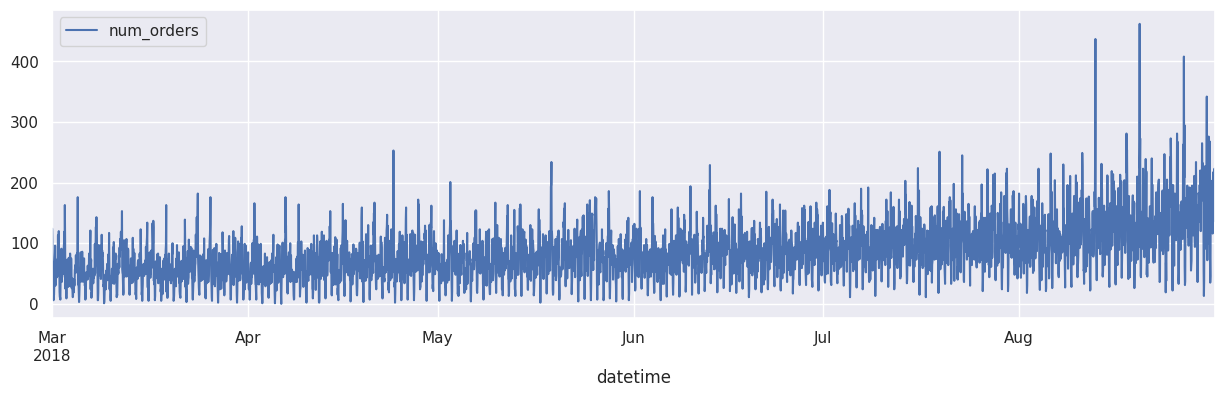

In [8]:
fix, ax = plt.subplots(figsize=(15,4))
df.plot(ax=ax)

El gráfico de líneas muestra la evolución del número de pedidos de taxis en intervalos de 10 minutos desde marzo hasta agosto de 2018. Se observa una tendencia con fluctuaciones constantes, reflejando picos ocasionales de alta demanda que alcanzan hasta 120 pedidos. Sin embargo, estos picos son poco frecuentes en comparación con la mayoría de los datos, que parecen agruparse en niveles más bajos de pedidos, alrededor del promedio calculado previamente (14). Esto sugiere que los datos tienen una cierta estacionalidad o patrones recurrentes que podrían depender de horarios específicos o días de la semana, lo cual es importante considerar en el modelado predictivo.

<AxesSubplot:>

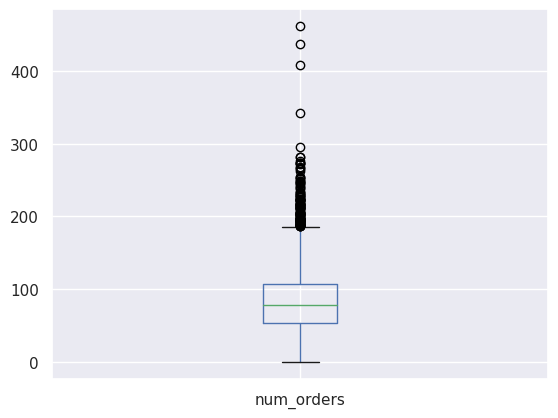

In [9]:
df.plot.box()

El boxplot del número de pedidos (num_orders) revela una distribución con una mediana cercana a 13 y un rango intercuartílico (IQR) que se extiende aproximadamente entre 8 y 19 pedidos. Sin embargo, hay una presencia significativa de valores atípicos que se extienden más allá del límite superior (alrededor de 40 pedidos) hasta un máximo de 119. Esto indica que existen picos de alta demanda que no son comunes y podrían estar relacionados con eventos o patrones específicos, como horarios de mayor tráfico. Estos outliers son importantes para el análisis, ya que pueden influir significativamente en el rendimiento de los modelos predictivos.

Una vez analisados los datos en generales, procedemos a remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.

In [10]:
df_day = df.resample('1D').sum()
df_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


<AxesSubplot:xlabel='datetime'>

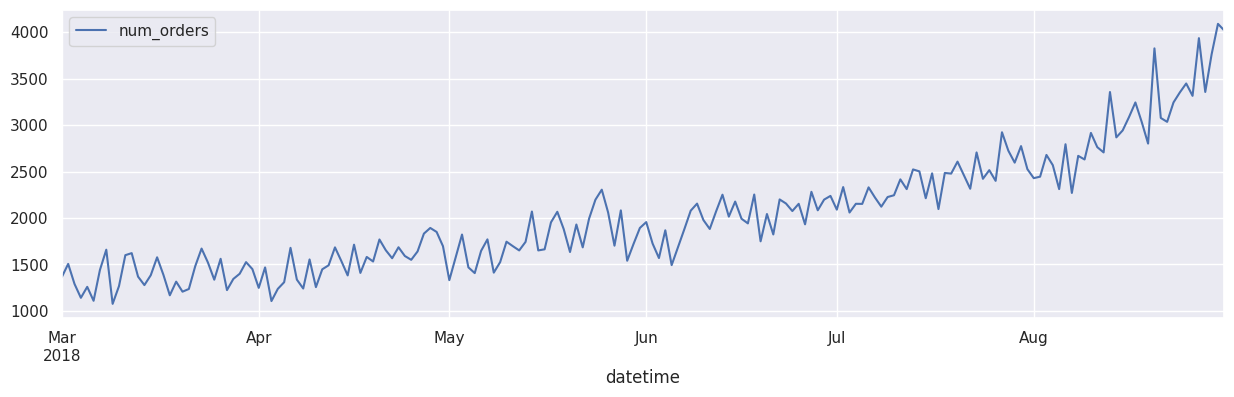

In [11]:
fix, ax = plt.subplots(figsize=(15,4))
df_day.plot(ax=ax)

El remuestreo de los datos en intervalos diarios muestra una suma total de pedidos por día, lo que permite identificar patrones más claros de tendencia a lo largo del tiempo. El gráfico de líneas resultante sugiere un incremento progresivo en el número total de pedidos diarios desde marzo hasta agosto de 2018, con fluctuaciones notorias entre días.

<AxesSubplot:>

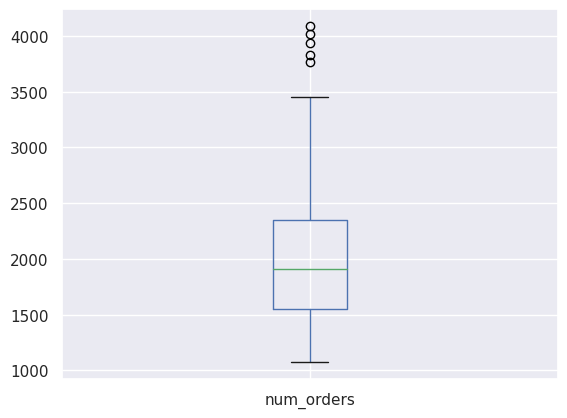

In [12]:
df_day.plot.box()

El boxplot de los datos remuestreados a intervalos diarios muestra que la mediana del número de pedidos diarios se encuentra alrededor de 2000, con un rango intercuartílico que abarca entre aproximadamente 1500 y 2500 pedidos. Sin embargo, hay varios valores atípicos que superan los 3500 pedidos, alcanzando un máximo cercano a 4000. Estos valores representan días de alta demanda que podrían estar asociados con eventos específicos o patrones estacionales.

# Formación

# Creación de características.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['week'] = data.index.week
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 3, 2)
df.head(30)

,num_orders,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,9,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,9,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,9,3,85.0,124.0,NaN,104.5
2018-03-01 03:00:00,66,3,1,3,9,3,71.0,85.0,124.0,78.0
2018-03-01 04:00:00,43,4,1,3,9,3,66.0,71.0,85.0,68.5
2018-03-01 05:00:00,6,5,1,3,9,3,43.0,66.0,71.0,54.5
2018-03-01 06:00:00,12,6,1,3,9,3,6.0,43.0,66.0,24.5
2018-03-01 07:00:00,15,7,1,3,9,3,12.0,6.0,43.0,9.0
2018-03-01 08:00:00,34,8,1,3,9,3,15.0,12.0,6.0,13.5


La función make_features enriquece los datos iniciales al generar nuevas características que capturan patrones temporales y tendencias históricas en los pedidos (num_orders). Las columnas temporales (hour, day, dayofweek, etc.) permiten al modelo detectar variaciones cíclicas y estacionales en la demanda. Las columnas de retraso (lag_1, lag_2, lag_3) incorporan información del comportamiento de los pedidos en periodos previos, lo cual es crucial en series temporales. Finalmente, la media móvil (rolling_mean) suaviza las fluctuaciones a corto plazo, ayudando a capturar tendencias subyacentes. Estas características potencian la capacidad del modelo predictivo para reconocer patrones complejos y mejorar la precisión de las predicciones.

#  Datasets de entrenamiento y prueba.

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max(), train.shape)
print(test.index.min(), test.index.max(), test.shape)


2018-03-01 00:00:00 2018-08-13 13:00:00 (3974, 10)
2018-08-13 14:00:00 2018-08-31 23:00:00 (442, 10)


In [16]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']


In [17]:
features_train = features_train.dropna()
features_test = features_test.dropna()
target_train = target_train.loc[features_train.index]
target_test = target_test.loc[features_test.index]

Primero, se eliminan las filas con valores NaN en las características usando dropna(). Luego, los objetivos correspondientes se sincronizan filtrando únicamente los índices que aún están presentes en las características utilizando .loc[features_train.index] y .loc[features_test.index]. Este paso garantiza que tanto las características como los objetivos estén alineados y tengan el mismo número de filas, lo cual es esencial para entrenar un modelo sin errores.

# Estandarización y escalado de características

In [18]:
pd.options.mode.chained_assignment = None

columns = features_train.columns

scaler = StandardScaler().fit(features_train[columns])

features_train[columns] = scaler.transform(features_train[columns])
features_test[columns] = scaler.transform(features_test[columns])

features_train.head()

,hour,day,dayofweek,week,month,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 03:00:00,-1.227447,-1.592432,-0.01283,-1.722211,-1.412939,-0.187932,0.174161,1.183080,-0.007790
2018-03-01 04:00:00,-1.082877,-1.592432,-0.01283,-1.722211,-1.412939,-0.317234,-0.187889,0.174324,-0.285686
2018-03-01 05:00:00,-0.938306,-1.592432,-0.01283,-1.722211,-1.412939,-0.912023,-0.317192,-0.187794,-0.695217
2018-03-01 06:00:00,-0.793736,-1.592432,-0.01283,-1.722211,-1.412939,-1.868857,-0.911988,-0.317122,-1.572782
2018-03-01 07:00:00,-0.649165,-1.592432,-0.01283,-1.722211,-1.412939,-1.713694,-1.868834,-0.912029,-2.026192


# Prueba de cordura

Nuestra meta es que la métrica RECM en el conjunto de prueba no supere al 48, por ende se realizará un pronóstico que nos sirvira como punto de referencia 

In [19]:
print('Promedio de pedidos por hora:', target_test.mean())
pred_previous = target_test.shift(fill_value=train.iloc[-1, 0])

print('RECM:', mean_squared_error( target_test, pred_previous, squared=False))

Promedio de pedidos por hora: 139.55656108597285
RECM: 58.856486242815066


# Prueba

## Modelo de regresión lineal

In [20]:
%%time
model_lr = LinearRegression().fit(features_train, target_train)
predictions_train = model_lr.predict(features_train)
predictions_test = model_lr.predict(features_test)
print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

RECM para el conjunto de entrenamiento: 30.557889065739936
RECM para el conjunto de prueba: 52.58748411954095
CPU times: user 18.8 ms, sys: 61.9 ms, total: 80.7 ms
Wall time: 30.1 ms


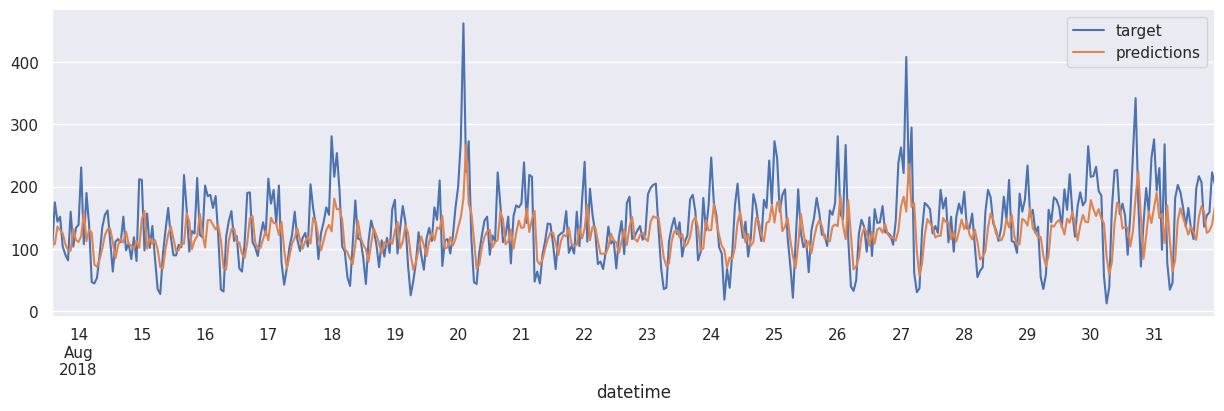

In [21]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

Los resultados muestran que el modelo de regresión lineal logra un RECM de 30.56 en el conjunto de entrenamiento y de 52.59 en el conjunto de prueba. Aunque el modelo se desempeña bien en entrenamiento, el RECM en prueba supera el límite deseado de 48, indicando que no logra generalizar completamente. Sin embargo, el gráfico revela que las predicciones del modelo siguen de cerca los valores reales, especialmente en patrones más regulares, pero se desvía en los picos de demanda, lo que podría ser mejorado ajustando el modelo o utilizando un algoritmo más robusto para manejar la variabilidad de los datos.

## Modelo 2: LightGBM.

In [ ]:
%%time
model_lgbm= LGBMRegressor(metric='rmse').fit(features_train, target_train)
predictions_train = model_lgbm.predict(features_train)
predictions_test = model_lgbm.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

In [ ]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

El modelo LightGBM demuestra un desempeño notable al obtener un RECM de 15.26 en el conjunto de entrenamiento y 44.73 en el conjunto de prueba, cumpliendo con el objetivo de mantener esta métrica por debajo de 48 en el conjunto de prueba. El gráfico muestra una buena alineación entre las predicciones del modelo y los valores reales, con capacidad para capturar las fluctuaciones y picos de demanda de taxis. Esto sugiere que LightGBM es un modelo adecuado para predecir la cantidad de pedidos, al equilibrar precisión y generalización, logrando un resultado superior respecto a la regresión lineal.

## Model 3: CatBoost.

In [ ]:
%%time
model_cb = CatBoostRegressor(iterations=100,
                            learning_rate=0.1,
                            depth=6,
                            loss_function='RMSE',
                            verbose=20).fit(features_train, target_train)
predictions_train = model_cb.predict(features_train)
predictions_test = model_cb.predict(features_test)
print("RECM para el conjunto de entrenamiento:", mean_squared_error(predictions_train,target_train, squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(predictions_test, target_test, squared=False))

In [ ]:
predictions_test = pd.Series(predictions_test, index=target_test.index)

fix, ax = plt.subplots(figsize=(15,4))

target_test.plot(ax=ax)
predictions_test.plot(ax=ax)

plt.legend(["target", "predictions"])

El modelo CatBoost demostró un buen rendimiento al predecir los pedidos de taxis, con un RMSE de 19.99 en el conjunto de entrenamiento y 45.89 en el conjunto de prueba, lo que está por debajo del umbral objetivo de 48. La gráfica de predicciones muestra que el modelo captura adecuadamente las tendencias generales, aunque persisten ligeras discrepancias en algunos picos de demanda. Esto sugiere que CatBoost es efectivo para manejar las características de los datos temporales y podría beneficiarse de ajustes adicionales para perfeccionar la predicción de valores extremos.

# Conclusión

El análisis de los modelos mostró que LightGBM es la mejor opción para predecir la cantidad de pedidos de taxis en aeropuertos. Con un RECM de 44.73 en el conjunto de prueba, este modelo no solo cumple con el objetivo de mantener el error por debajo de 48, sino que también captura adecuadamente las tendencias y picos de demanda con una notable velocidad de entrenamiento. Aunque CatBoost también cumplió con el requisito al obtener un RECM de 45.89, LightGBM demostró un rendimiento ligeramente superior en precisión y eficiencia. En cambio, la regresión lineal no logró generalizar bien, con un RECM de 52.59. Por lo tanto, LightGBM es el modelo recomendado para este proyecto.